In [1]:
import sys
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from cycler import cycler

plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['axes.labelsize'] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['figure.figsize'] = [10, 7]

cc = (cycler(linestyle=['-', '--', '-.']) * cycler(color=list('bgrcmk')))

plt.rc('axes', prop_cycle=cc)

In [2]:
#os.environ['OFT_ROOTPATH'] = '/Users/ansonbraun/Documents/Columbia/Research/OpenFUSIONToolkit/src/'

thincurr_python_path = os.getenv('OFT_ROOTPATH')
if thincurr_python_path is not None:
    sys.path.append(os.path.join(thincurr_python_path,'python'))
#sys.path.append('/Users/sophiaguizzo/Documents/OFT_thincurr/install_release/python')
from OpenFUSIONToolkit.ThinCurr import ThinCurr
from OpenFUSIONToolkit.ThinCurr.sensor import circular_flux_loop, save_sensors, flux_loop
from OpenFUSIONToolkit.util import build_XDMF
from OpenFUSIONToolkit.io import histfile
from OpenFUSIONToolkit.TokaMaker.util import create_isoflux, read_eqdsk

In [3]:
arc_eq = read_eqdsk('../geqdsk-FreeGS-ARC-v2E-20250105.txt')
lim = arc_eq['rzlim']

In [4]:
arc_torus = ThinCurr(nthreads=4)

arc_torus.setup_model(mesh_file = 'vacuum_mesh.h5', xml_filename = 'arc_200_coils.xml')
arc_torus.setup_io()

rerun = True

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   main
Revision id:          2c5f6aa
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    4
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------


Creating thin-wall model
 Orientation depth =           6
  Loading V(t) driver coils
  Loading I(t) driver coils

  # of points    =            9
  # of edges     =           16
  # of cells     =            8
  # of holes     =            0
  # of Vcoils    =            0
  # of closures  =            0
  # of Icoils    =            1

  Building holes

  Loading region resistivity:
     1

In [5]:
#Computing self-interactions matrices
arc_torus.compute_Mcoil()
#sparc_torus.compute_Lmat(use_hodlr=True, cache_file = 'sparc_sensor_lmat')
arc_torus.compute_Mcoil()
arc_torus.compute_Lmat(use_hodlr=True)
arc_torus.compute_Rmat()

 Building coil<->element inductance matrices
     Time =  0s          
 Building coil<->coil inductance matrix
 Building coil<->element inductance matrices
     Time =  0s          
 Building coil<->coil inductance matrix
 Partitioning grid for block low rank compressed operators
   nBlocks =                   1
   Avg block size =            1
   # of SVD =                  0
   # of ACA =                  0

 Building block low rank inductance operator
   Building hole and Vcoil columns
   Building diagonal blocks
   Building off-diagonal blocks using ACA+
     Compression ratio: 100.0%  ( 1.00E+00/ 1.00E+00)
     Time =  0s          
 Building resistivity matrix


In [6]:
loop = np.column_stack((lim[:,0],np.zeros(len(lim[:,0])),lim[:,1]))
sensors = [
    flux_loop(loop,'Loop_1' )
]

save_sensors(sensors)
Msensor, Msc, sensor_obj = arc_torus.compute_Msensor('floops.loc')


 Loading floop information:
   # of floops =           1
 Building element->sensor inductance matrix
 Building coil->sensor inductance matrix


In [7]:
t_steps_I = np.array([-0.5e-3, 0, 0.1e-3,  0.5e-3])

plasma_I = np.array([0.0e6, 0.0e6, 5.6605E3, 5.6605E3]) #200 coils
VF_I = np.array([0.0, 0.0, 0.0, 0.0])

curr_arr = np.stack((t_steps_I, plasma_I)).T 
v_arr = np.stack((t_steps_I, VF_I)).T 

In [8]:
dt = 0.1e-4
nsteps = 50

#reset all of the files:
run_files = [f for f in os.listdir('.') if f.endswith('.rst') or f.endswith('.xmf')]
for file in run_files:
    os.remove(file)

#arc_torus.run_td(dt,nsteps,status_freq=1,plot_freq=1,coil_currs=curr_arr)
arc_torus.run_td(dt,nsteps,status_freq=1,plot_freq=1,coil_currs=curr_arr, sensor_obj = sensor_obj)
arc_torus.plot_td(nsteps, plot_freq = 1)
arc_torus.build_XDMF()


 Starting simulation
 Timestep            1   9.99999975E-06   1.92112655E-29           1
 Timestep            2   1.99999995E-05   6.40375543E-30           1
 Timestep            3   2.99999992E-05   1.92112655E-29           1
 Timestep            4   3.99999990E-05   6.40375543E-30           1
 Timestep            5   4.99999987E-05   1.92112655E-29           1
 Timestep            6   5.99999985E-05   6.40375543E-30           1
 Timestep            7   7.00000019E-05   1.92112655E-29           1
 Timestep            8   7.99999980E-05   6.40375543E-30           1
 Timestep            9   9.00000014E-05   1.92112655E-29           1
 Timestep           10   9.99999975E-05   3.91375711E-38           1
 Timestep           11   1.10000001E-04   6.40375543E-30           1
 Timestep           12   1.19999997E-04   6.40375543E-30           1
 Timestep           13   1.30000000E-04   6.40375543E-30           1
 Timestep           14   1.40000004E-04   6.40375543E-30           1
 Timestep   

0.34940104689181367


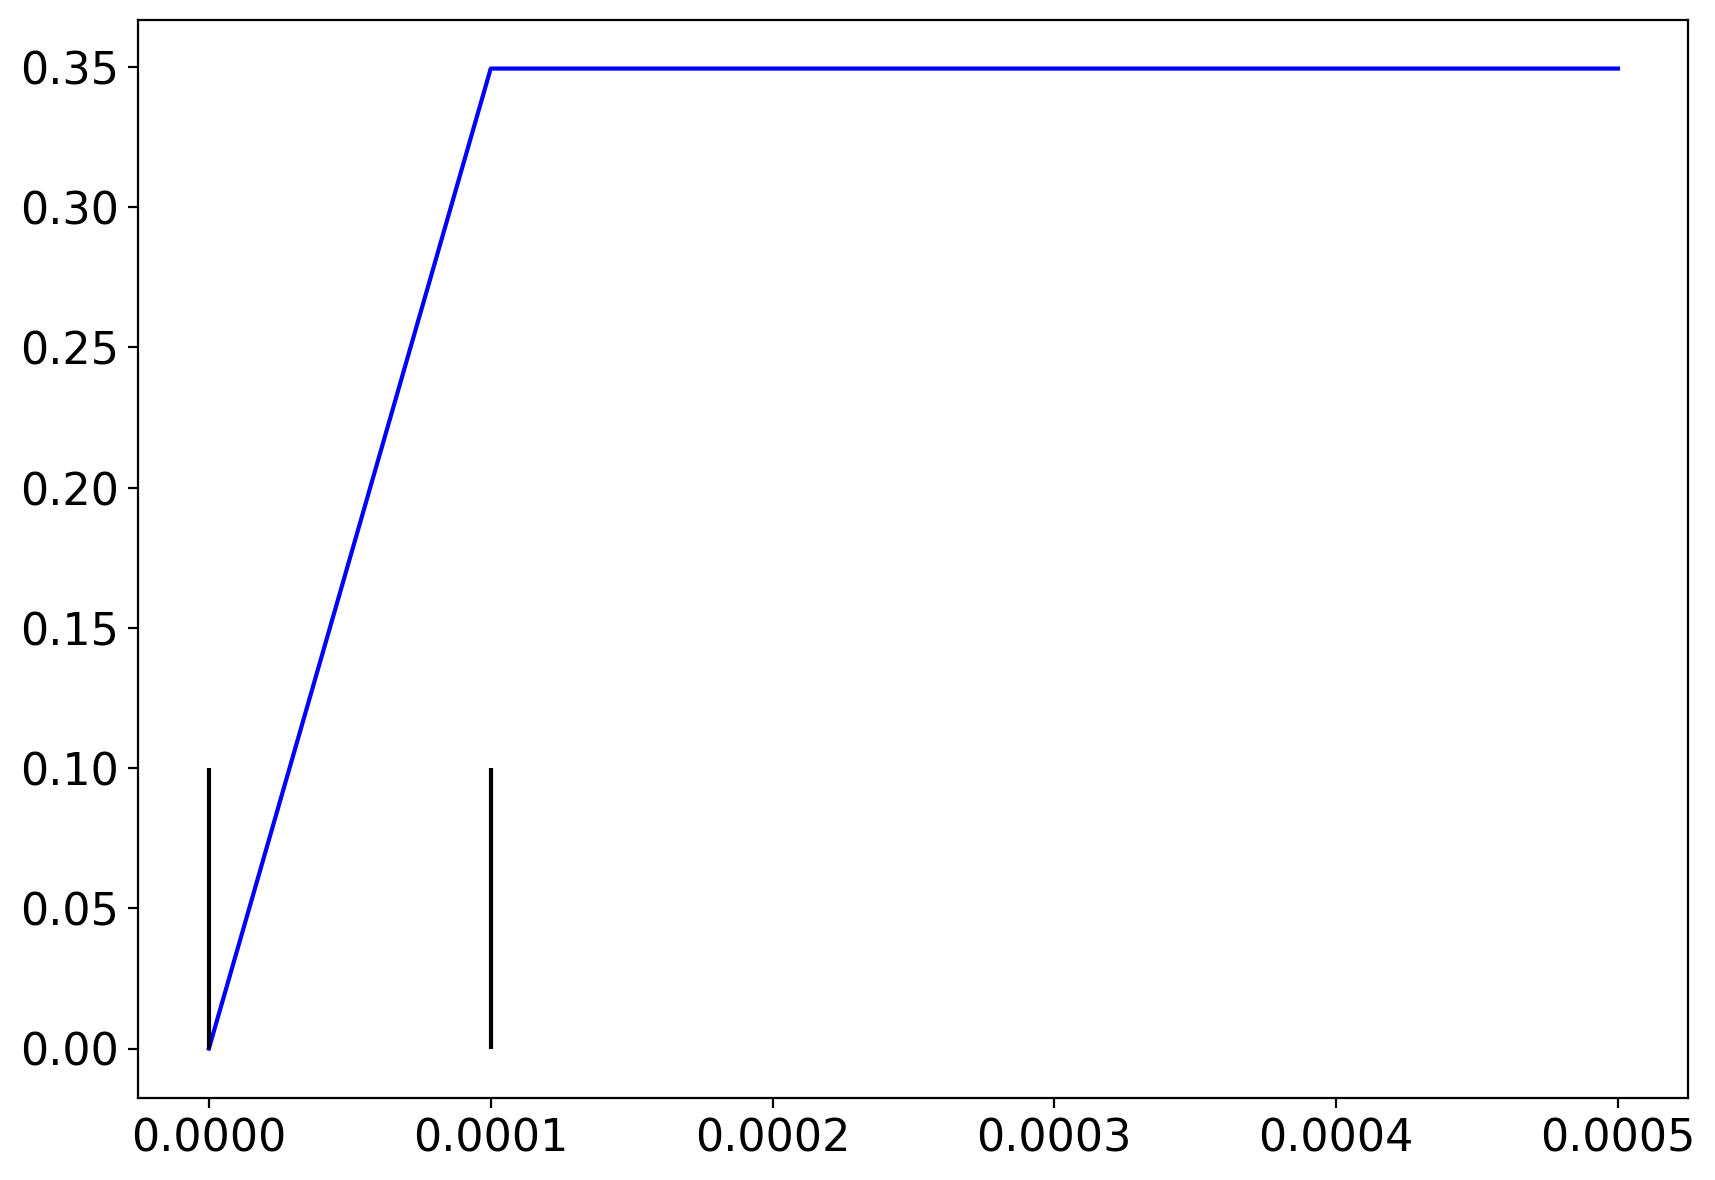

In [9]:
hist_file = histfile('floops.hist')
print(np.max(-hist_file['Loop_1']))

fig, ax = plt.subplots(1,1)
ax.plot(hist_file['time'],-hist_file['Loop_1'])
#ax.set_ylim(bottom=0.0)
#_ = ax.set_xlim(left=0.0)
ax.vlines(x = [0.0,0.1E-3], ymin = 0, ymax = 0.1, color = 'k')

In [10]:
#arc diamagnetic flux is 0.3493384922757648